#LA , Nevada

Train on Year 2019-20 & test on 2021




In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler ,MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.pipeline import Pipeline
import joblib

# Load your primary dataset
df_n = pd.read_csv("/content/LA_Nevada_2019_20.csv")
df_n['Datetime'] = pd.to_datetime(df_n[['Year', 'Month', 'Day', 'Hour', 'Minute']])
df_n.set_index('Datetime', inplace=True)
# Now your DataFrame 'df' contains a 'Datetime' column

df = df_n[df_n['is_day']==True]

# Select the input and target columns
input_columns = ['GHI', 'Temperature', 'Relative Humidity', 'Solar Zenith Angle']
target_columns = input_columns

# Create lag features to prepare time series data
def create_lagged_data(data, lag=432):
    X, y = [], []
    for i in range(len(data) - lag):
        X.append(data[i:i+lag])
        y.append(data[i+lag])
    return np.array(X), np.array(y)

lag = 1000  #432
X, y = create_lagged_data(df[input_columns].values, lag=lag)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.8, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scale your data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 4)).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val.reshape(-1, 4)).reshape(X_val.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, 4)).reshape(X_test.shape)

# Create a pipeline with LSTM model and early stopping
pipeline = Sequential([
    LSTM(64, input_shape=(lag, len(input_columns)), return_sequences=True),
    LSTM(32, return_sequences=False),
    Dropout(0.02),
    Dense(len(target_columns))  # Output layer has the same number of units as target columns
])

# Compile your model
pipeline.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=[RootMeanSquaredError()])

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)

# Fit the pipeline on your training data with early stopping
pipeline.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=150, callbacks=[early_stopping])

# Save the entire pipeline including the LSTM model
joblib.dump(scaler, 'scaler.joblib')
pipeline.save('lstm_model.h5')



Epoch 1/150
329/329 [==============================] - 49s 121ms/step - loss: 77864.7969 - root_mean_squared_error: 279.0426 - val_loss: 75492.3516 - val_root_mean_squared_error: 274.7587
Epoch 2/150
329/329 [==============================] - 38s 115ms/step - loss: 74821.6328 - root_mean_squared_error: 273.5354 - val_loss: 72812.5469 - val_root_mean_squared_error: 269.8380
Epoch 3/150
329/329 [==============================] - 38s 114ms/step - loss: 72251.5547 - root_mean_squared_error: 268.7965 - val_loss: 70365.3281 - val_root_mean_squared_error: 265.2646
Epoch 4/150
329/329 [==============================] - 37s 113ms/step - loss: 69876.1953 - root_mean_squared_error: 264.3411 - val_loss: 68066.5781 - val_root_mean_squared_error: 260.8957
Epoch 5/150
329/329 [==============================] - 37s 112ms/step - loss: 67617.2344 - root_mean_squared_error: 260.0331 - val_loss: 65882.2109 - val_root_mean_squared_error: 256.6753
Epoch 6/150
329/329 [==============================] - 37s 1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
y_pred = pipeline.predict(X_test_scaled)

658/658 [==============================] - 16s 23ms/step


In [ ]:
import pandas as pd

# Assuming y_pred and y_test are NumPy arrays or Pandas DataFrames
y_pred_df = pd.DataFrame(y_pred, columns =  ['GHI_p','Temperature_p', 'Relative Humidity_p', 'Solar Zenith Angle_p'])
y_test_df = pd.DataFrame(y_test, columns= ['GHI', 'Temperature', 'Relative Humidity', 'Solar Zenith Angle'])

# Combine the DataFrames
final_df = pd.concat([y_test_df, y_pred_df], axis=1)

# Print the combined DataFr
final_df

,GHI,Temperature,Relative Humidity,Solar Zenith Angle,GHI_p,Temperature_p,Relative Humidity_p,Solar Zenith Angle_p
0,267.0,35.9,7.29,72.42,256.747467,33.326065,8.451759,70.857147
1,112.0,26.3,27.99,44.03,196.842590,16.805565,21.874405,49.919044
2,252.0,12.1,13.08,75.30,260.062592,22.870066,23.004620,70.722862
3,743.0,22.7,29.06,43.29,742.152283,20.817575,26.539822,43.605446
4,111.0,27.0,23.37,15.86,437.022278,20.277092,10.662244,33.495415
...,...,...,...,...,...,...,...,...
21029,811.0,39.6,10.10,37.21,806.179016,38.858738,6.431192,39.937595
21030,690.0,32.4,9.97,47.13,684.248230,33.390499,10.375716,48.816547
21031,33.0,18.8,29.10,86.67,39.545925,16.331154,33.846367,84.875816
21032,348.0,18.7,49.43,68.38,344.917755,13.741056,38.192127,67.498070


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)

# Calculate R2 score
r2 = r2_score(y_test, y_pred)

# Print the results
print(f'RMSE: {rmse}')
print(f'MSE: {mse}')
print(f'R2 Score: {r2}')


RMSE: 25.849908234562037
MSE: 668.2177557352782
R2 Score: 0.8938525860499729


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(final_df['GHI'], final_df['GHI_p']))

# Calculate MSE
mse = mean_squared_error(final_df['GHI'], final_df['GHI_p'])

# Calculate R2 score
r2 = r2_score(final_df['GHI'], final_df['GHI_p'])

# Print the results
print(f'RMSE: {rmse}')
print(f'MSE: {mse}')
print(f'R2 Score: {r2}')


RMSE: 51.018413790022784
MSE: 2602.8785456499872
R2 Score: 0.9734608443776166


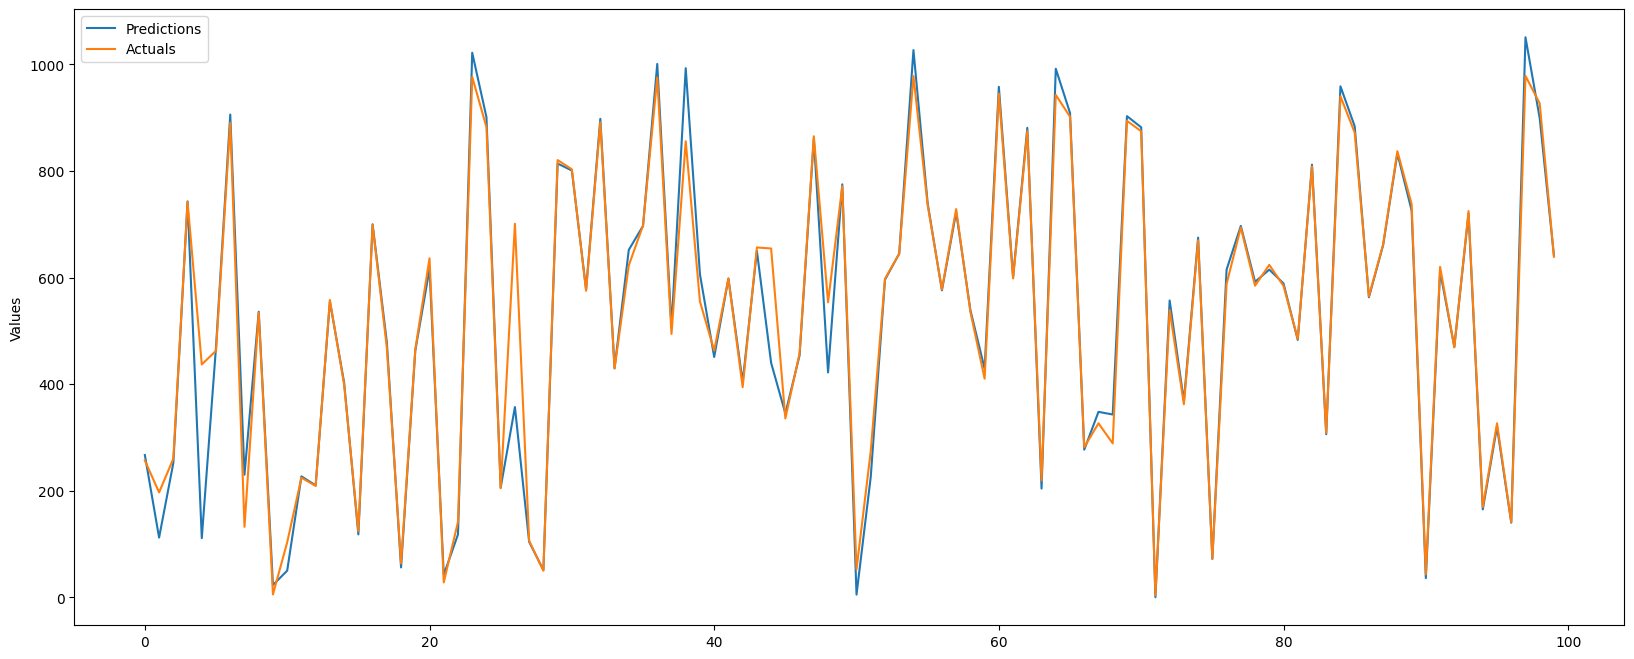

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(final_df['GHI'][:100])
plt.plot(final_df['GHI_p'][:100])
plt.xticks(rotation=0)
plt.ylabel('Values')
plt.legend(['Predictions', 'Actuals'])
plt.show()

In [ ]:
plt.savefig('multi_19_20.jpeg')

<Figure size 640x480 with 0 Axes>

In [ ]:
final_df.describe()

,GHI,Temperature,Relative Humidity,Solar Zenith Angle,GHI_p,Temperature_p,Relative Humidity_p,Solar Zenith Angle_p
count,21034.000000,21034.000000,21034.000000,21034.000000,21034.000000,21034.000000,21034.000000,21034.000000
mean,469.086051,25.673909,20.832165,58.113822,470.656281,25.808163,20.268175,58.067265
std,313.179788,10.638340,14.409482,21.181290,306.201080,9.416698,13.368844,20.025116
min,0.000000,0.100000,2.530000,12.730000,-8.721283,2.991852,-3.974351,10.938030
25%,191.000000,16.600000,10.162500,42.670000,198.150673,18.169383,10.228784,42.519885
50%,470.000000,25.900000,16.170000,59.290000,473.571030,27.524594,16.358698,58.972534
75%,731.000000,34.800000,27.710000,73.847500,730.294342,33.411459,27.210054,72.955528
max,1083.000000,46.400000,91.510000,103.450000,978.823181,48.589676,67.653656,101.919205


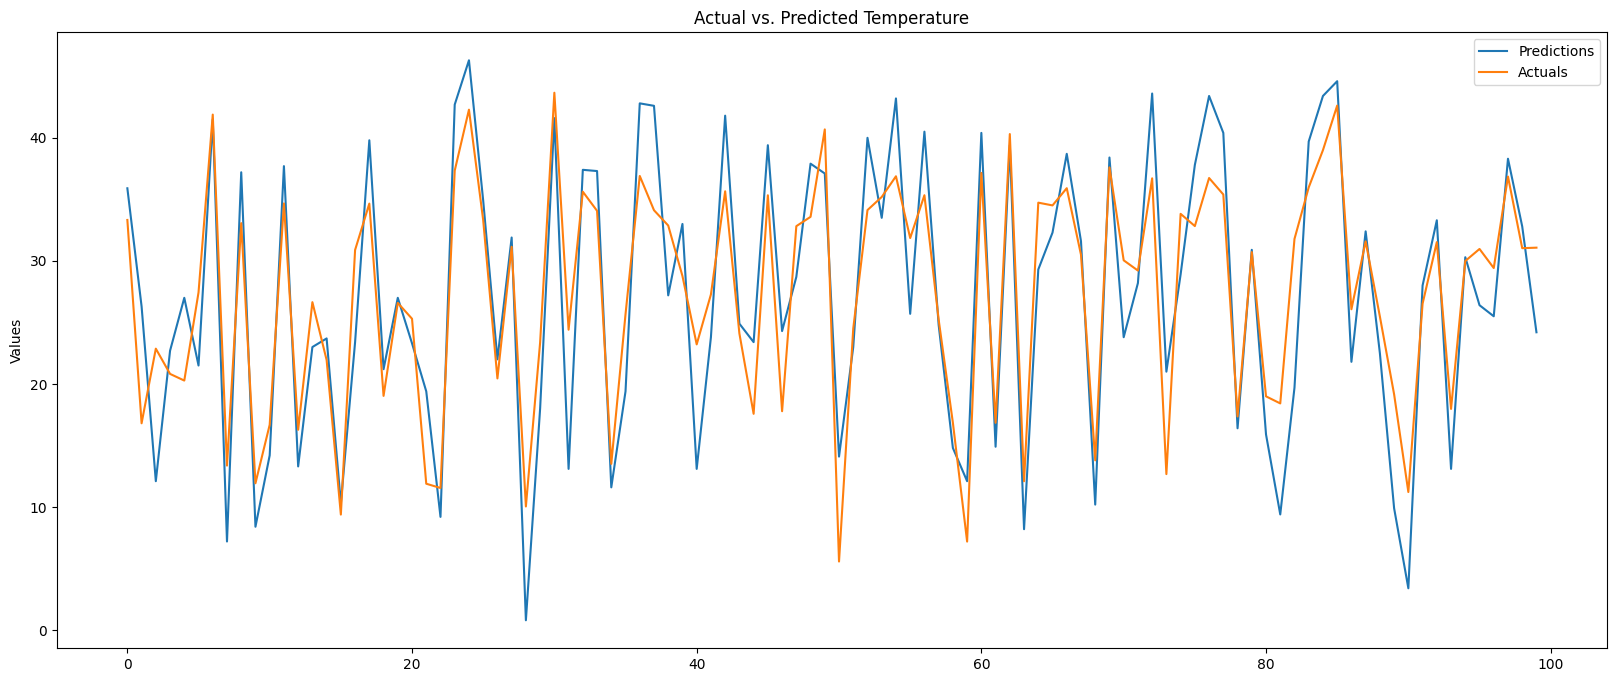

In [ ]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(20, 8))

# Plot the first 100 data points of 'Temperature' and 'Temperature_p'
plt.plot(final_df['Temperature'][:100])
plt.plot(final_df['Temperature_p'][:100])

# Customize the plot
plt.xticks(rotation=0)
plt.ylabel('Values')
plt.legend(['Predictions', 'Actuals'])
plt.title('Actual vs. Predicted Temperature')

# Show the plot
plt.show()



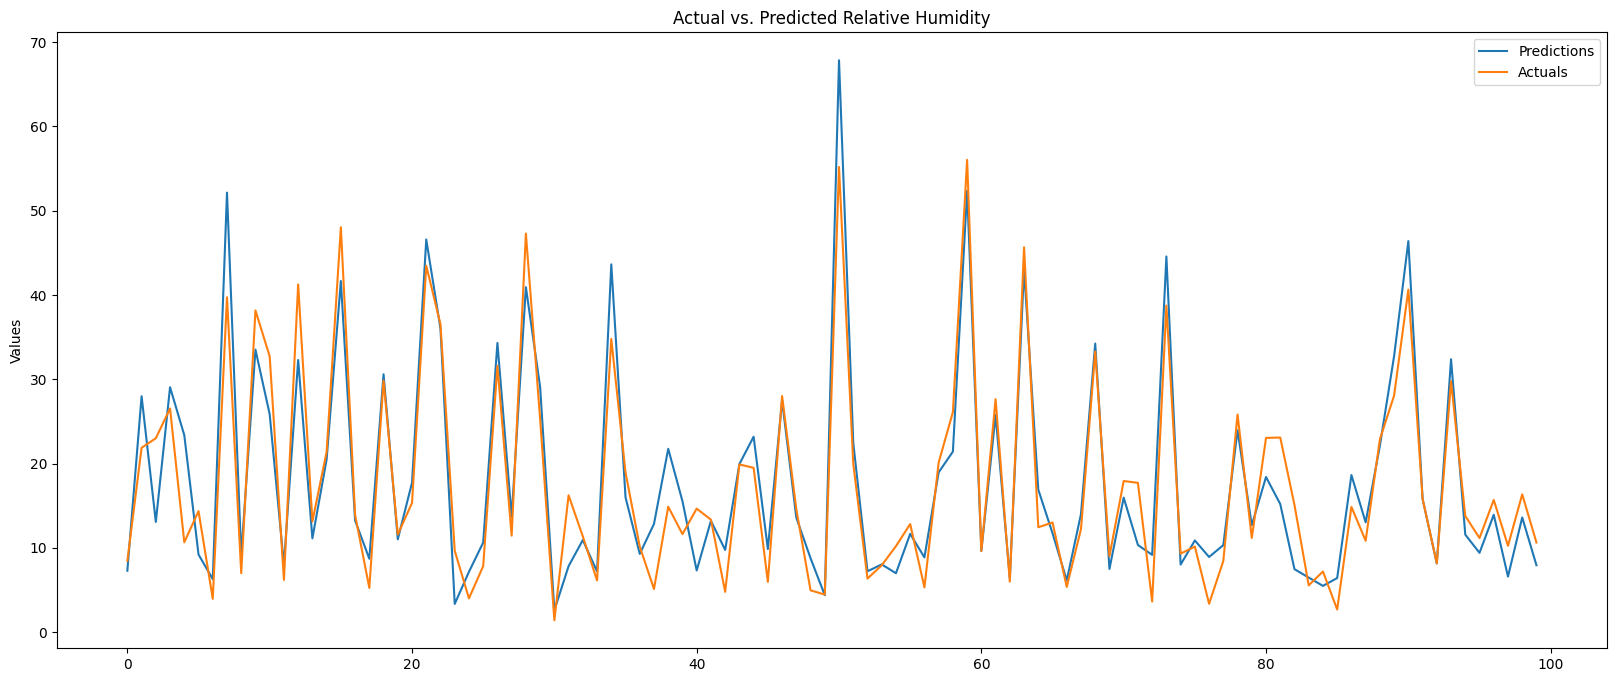

In [ ]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(20, 8))

# Plot the first 100 data points of 'Relative Humidity' and 'Relative Humidity_p'
plt.plot(final_df['Relative Humidity'][:100])
plt.plot(final_df['Relative Humidity_p'][:100])

# Customize the plot
plt.xticks(rotation=0)
plt.ylabel('Values')
plt.legend(['Predictions', 'Actuals'])
plt.title('Actual vs. Predicted Relative Humidity')

# Show the plot
plt.show()


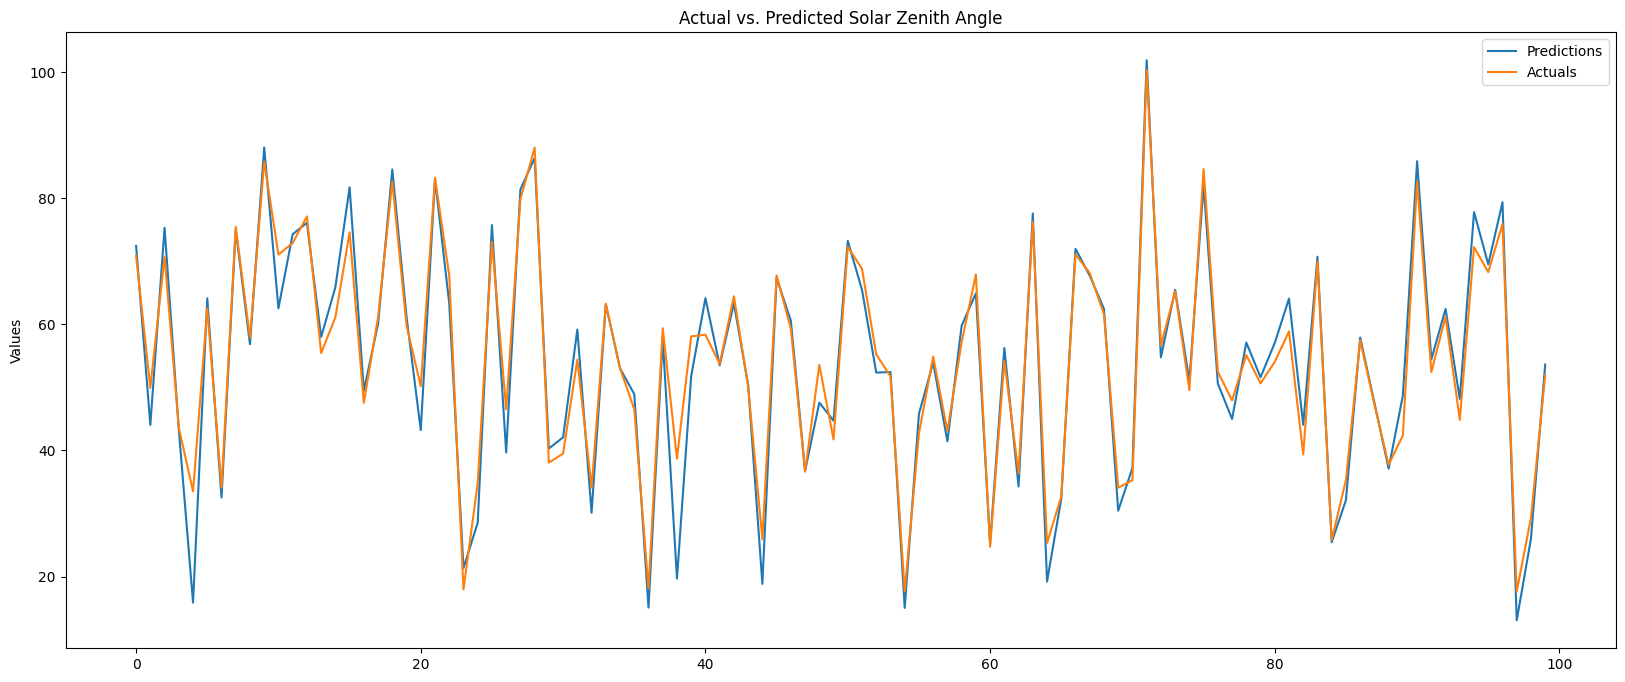

In [ ]:

# Set the figure size
plt.figure(figsize=(20, 8))

# Plot the first 100 data points of 'Solar Zenith Angle' and 'Solar Zenith Angle_p'
plt.plot(final_df['Solar Zenith Angle'][:100])
plt.plot(final_df['Solar Zenith Angle_p'][:100])

# Customize the plot
plt.xticks(rotation=0)
plt.ylabel('Values')
plt.legend(['Predictions', 'Actuals'])
plt.title('Actual vs. Predicted Solar Zenith Angle')

# Show the plot
plt.show()
